# Computing ab inito U value using the linear response method with CASTEP

## How to run

1. Have CASTEP compiled and `castep.mpi` in the `$PATH`
2. `base script.sh`
3. Run this notebook or `python post-process.py`

## How it works

Adjust the `HUBBARD_ALPHA` value and record the initial and final occupations of the Mn d levels when continuing from the unperturbed run (`base_calc`).
The value of U is extracted using the gradient of the two response curves.

The example in  http://hjkgrp.mit.edu/content/calculating-hubbard-u is reused here and the same methodology is followed.  
The more `self-consistent` U can be computed by repeating the procedure with different input value for the U.


Reference: 
>  Cococcioni, M.; de Gironcoli, S. Linear Response Approach to the Calculation of the Effective Interaction Parameters in the LDA+U Method. Phys. Rev. B 2005, 71 (3), 035105. https://doi.org/10.1103/PhysRevB.71.035105.

DISCLAIMER: Use at your own risk. Please raise an issue if you think the method here is not correct due to implementation details.


## Post-processing the results

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_occ(lines):
    """
    Read occupations from a continuation CASTEP calculation
    Arguments:
        lines: a list of lines to be computed
        
    Returns:
        occupation for the non-selfconsistn and self-conssistent occupation number
    """
    in_block = False
    in_cell = False
    tot_occs = []
    for i, line in enumerate(lines):
        if "Hubbard U occupation numbers" in line:
            in_block = True
            continue
        if line.startswith("====") and in_block and not in_cell:
            in_cell = True
            continue
        if in_cell and line.startswith("===="):
            in_cell = False
            in_block = False
            continue
        if in_cell:
            tokens = line.split()
            tot_occ = sum(map(float, tokens[-5:]))
            tot_occs.append(tot_occ)
    return tot_occs[2] + tot_occs[3], tot_occs[-2] + tot_occs[-1]#, tot_occs


In [3]:
res = []
for path in Path().glob("alpha*/*.castep"):
    tmp = read_occ(path.read_text().split('\n'))
    sc = tmp[1]
    nsc = tmp[0]
    alpha = float(str(path.parent).split('_')[1])
    res.append([alpha, nsc, sc])
res.sort(key=lambda x: x[0])

res = np.asarray(res)

Fit and obtain the value of U

Calculatd U value: 3.31 eV


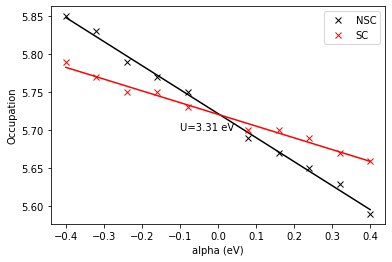

In [10]:
nsc_fit = np.poly1d(np.polyfit(res[:, 0], res[:, 1], 1))
sc_fit = np.poly1d(np.polyfit(res[:, 0], res[:, 2], 1))

alpha, nsc, sc = res.T
plt.plot(alpha, nsc, 'xk', label='NSC')
plt.plot(alpha, nsc_fit(alpha), '-k')
plt.plot(alpha, sc, 'xr', label='SC')
plt.plot(alpha, sc_fit(alpha), '-r')
plt.legend()
plt.xlabel("alpha (eV)")
plt.ylabel("Occupation")

U = 1/nsc_fit.coeffs[0] - 1/sc_fit.coeffs[0]
print("Calculatd U value: {:.2f} eV".format(U))
plt.annotate("U={:.2f} eV".format(U), (-0.1, 5.70))
plt.savefig("response.png")


## Comments
Accuracy of the U is limited by the occupation being only accurate to 2 decimal places.  
The source code of CASTEP may be modified to enable more output of the occupation numbers with more decimal places.  
Alternatively, one may use a larger scan range for alpha.